<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/20_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output

In [3]:
files.upload()
clear_output()

In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.31G/1.33G [00:07<00:00, 211MB/s]
100% 1.33G/1.33G [00:07<00:00, 191MB/s]


In [22]:
!unzip celeba-dataset.zip
!mkdir dataset
!mv img_align_celeba/img_align_celeba/ dataset
!rm -rf *.csv
!rm -rf *.zip
clear_output()

In [24]:
!rm -rf celeba-dataset.zip

In [8]:
import os
import glob
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision as tv
import torchvision.transforms as T

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [42]:
DATASET_PATH = 'dataset/img_align_celeba/'

IMAGE_SIZE = 64
LATENT_DIM = 128
BATCH_SIZE = 4
EPOCHS = 1
LR = 1e-3

LAMBDA = .1

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class CelebADataset(Dataset):
  def __init__(self, root, transforms=None):
    self.images = glob.glob(f'{root}/*.jpg')

    self.transforms = transforms

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    image = Image.open(image).convert('RGB')

    if self.transforms:
      image = self.transforms(image)

    return image

In [11]:
class EncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

  def forward(self, x):
    return self.layers(x)

In [12]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
    )

  def forward(self, x):
    return self.layers(x)

In [13]:
class DecoderOutput(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.conv_layers = nn.Sequential(
        EncoderBlock(3, 32),
        EncoderBlock(32, 64),
        EncoderBlock(64, 128),
        EncoderBlock(128, 256),
        EncoderBlock(256, 512)
    )

    self.mu = nn.Linear(512 * 4, latent_dim)
    self.log_std = nn.Linear(512 * 4, latent_dim)

  def forward(self, x):
    x = self.conv_layers(x)
    x = torch.flatten(x, start_dim=1)

    mu = self.mu(x)
    log_std = self.log_std(x)

    return mu, log_std

In [15]:
class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.conv_layers = nn.Sequential(
        DecoderBlock(512, 256),
        DecoderBlock(256, 128),
        DecoderBlock(128, 64),
        DecoderBlock(64, 32),
        DecoderBlock(32, 32),
        DecoderOutput(32, 3)
    )

    self.input_layer = nn.Linear(latent_dim, 512 * 4)

  def forward(self, x):
    x = self.input_layer(x)
    x = x.view(-1, 512, 2, 2)

    x = self.conv_layers(x)

    return x

In [16]:
def reparameterize(mu, log_std):
  std = torch.exp(.5 * log_std)
  eps = torch.randn_like(mu)

  z = mu + eps * std
  return z

In [17]:
mse_loss = nn.MSELoss()

def criterion(x, reconstructed_x, mu, log_std):
  reconstruction_loss = mse_loss(x, reconstructed_x)
  kld_loss = torch.sum( -.5 * torch.sum(1 + log_std - mu ** 2 - log_std.exp(), dim=1) ,dim=0)

  return reconstruction_loss + LAMBDA * kld_loss

In [25]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE))
])

dataset = CelebADataset(DATASET_PATH, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
encoder = Encoder(LATENT_DIM).to(DEVICE)
decoder = Decoder(LATENT_DIM).to(DEVICE)

In [27]:
optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=LR)

In [30]:
for epoch in range(1, EPOCHS + 1):
  print(f'Epoch {epoch}/{EPOCHS}')
  total_loss = .0
  for image in tqdm(dataloader):
    optimizer.zero_grad()

    image = image.to(DEVICE)
    mu, log_std = encoder(image)
    z = reparameterize(mu, log_std)
    reconstucted_image = decoder(z)

    loss = criterion(image, reconstucted_image, mu, log_std)
    loss.backward()
    optimizer.step()

    total_loss += loss.detach().cpu().item()

  print(f'loss: {total_loss:.2f}')

Epoch 1/1


  0%|          | 0/50650 [00:00<?, ?it/s]

loss: 4961.29


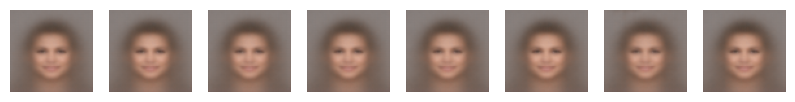

In [41]:
num_images = 8

with torch.no_grad():
  noise = torch.randn(num_images, LATENT_DIM).to(DEVICE)
  generated_images = decoder(noise).cpu().numpy()

fig, axs = plt.subplots(1, num_images, figsize=(10, 8))
for i in range(num_images):
  image = generated_images[i].transpose((1, 2, 0))
  axs[i].imshow(image)
  axs[i].axis('off')

plt.show()